In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from IPython.display import display

from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Housing.csv')

#df.drop(['dteday','instant'], axis=1, inplace=True)
display(df.head())

target = 'price'
features = [i for i in df.columns if i not in [target]]

original_df = df.copy(deep=True)

print('\n\033[1mInference:\033[0m The Dataset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished



Inference: The Dataset consists of 13 features & 545 samples.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [4]:
df.nunique().sort_values()

mainroad              2
guestroom             2
basement              2
hotwaterheating       2
airconditioning       2
prefarea              2
furnishingstatus      3
bathrooms             4
stories               4
parking               4
bedrooms              6
price               219
area                284
dtype: int64

In [5]:
nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=16:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Dataset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Dataset has 1 numerical & 11 categorical features.


In [6]:
display(df.describe())

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


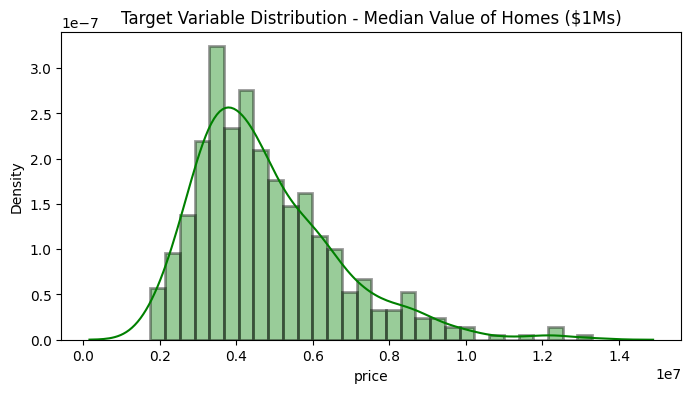

In [7]:
plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

                               Visualising Categorical Features:                                


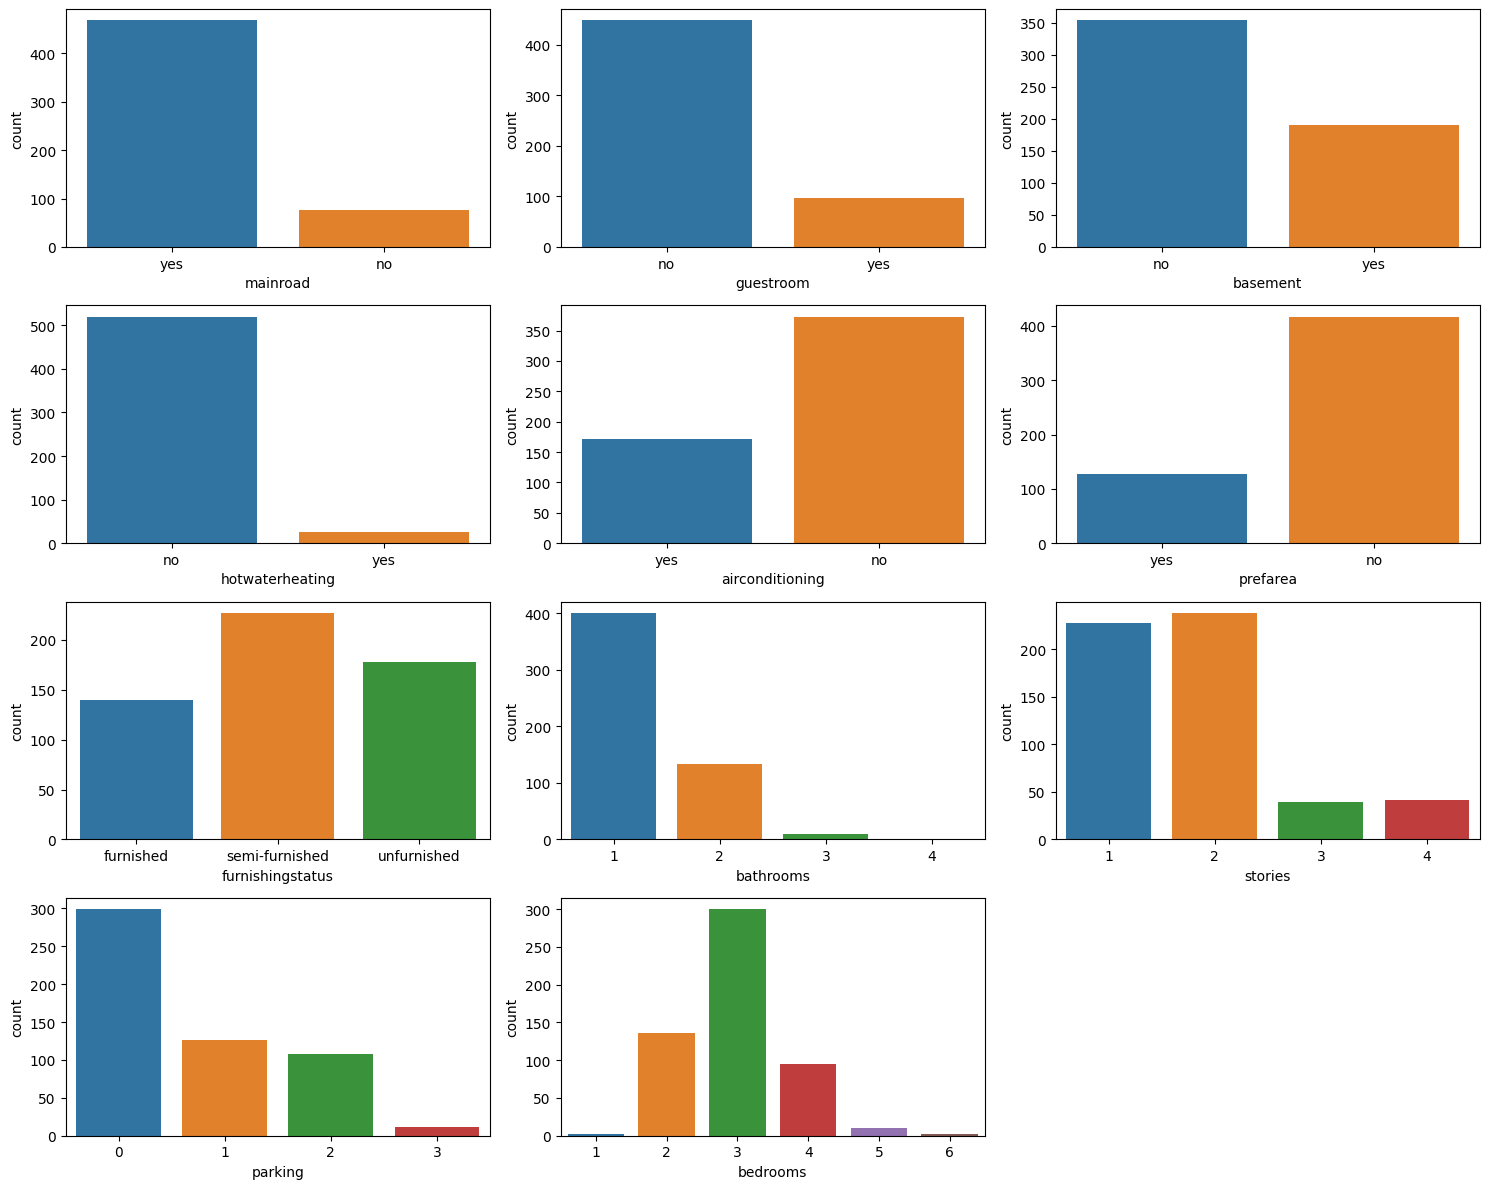

In [8]:
print('\033[1mVisualising Categorical Features:'.center(100))

n = 3
plt.figure(figsize=[15, 3 * math.ceil(len(cf) / n)])

for i in range(len(cf)):
    if df[cf[i]].nunique() <= 8:
        plt.subplot(math.ceil(len(cf) / n), n, i + 1)
        sns.countplot(data=df, x=cf[i])
    else:
        plt.subplot(math.ceil(len(cf) / n), n, i + 1)
        sns.countplot(data=df, x=cf[i], hue='target')

plt.tight_layout()
plt.show()



                                                Numeric Features Distribution                                                 


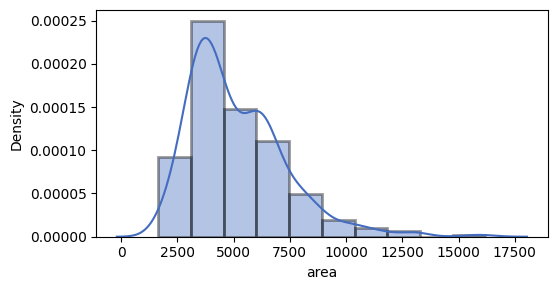

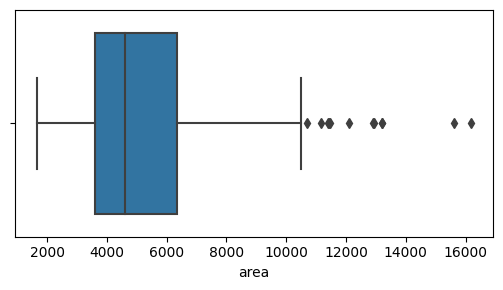

In [9]:
print('\033[1mNumeric Features Distribution'.center(130))

n=3

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/n),n,i+1)
    sns.distplot(df[nf[i]], hist_kws=dict(edgecolor="black",linewidth=2),bins=10, color=list(np.random.rand(3)))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/n),n,i+1)
    sns.boxplot(data=df, x=nf[i])
plt.tight_layout()
plt.show()

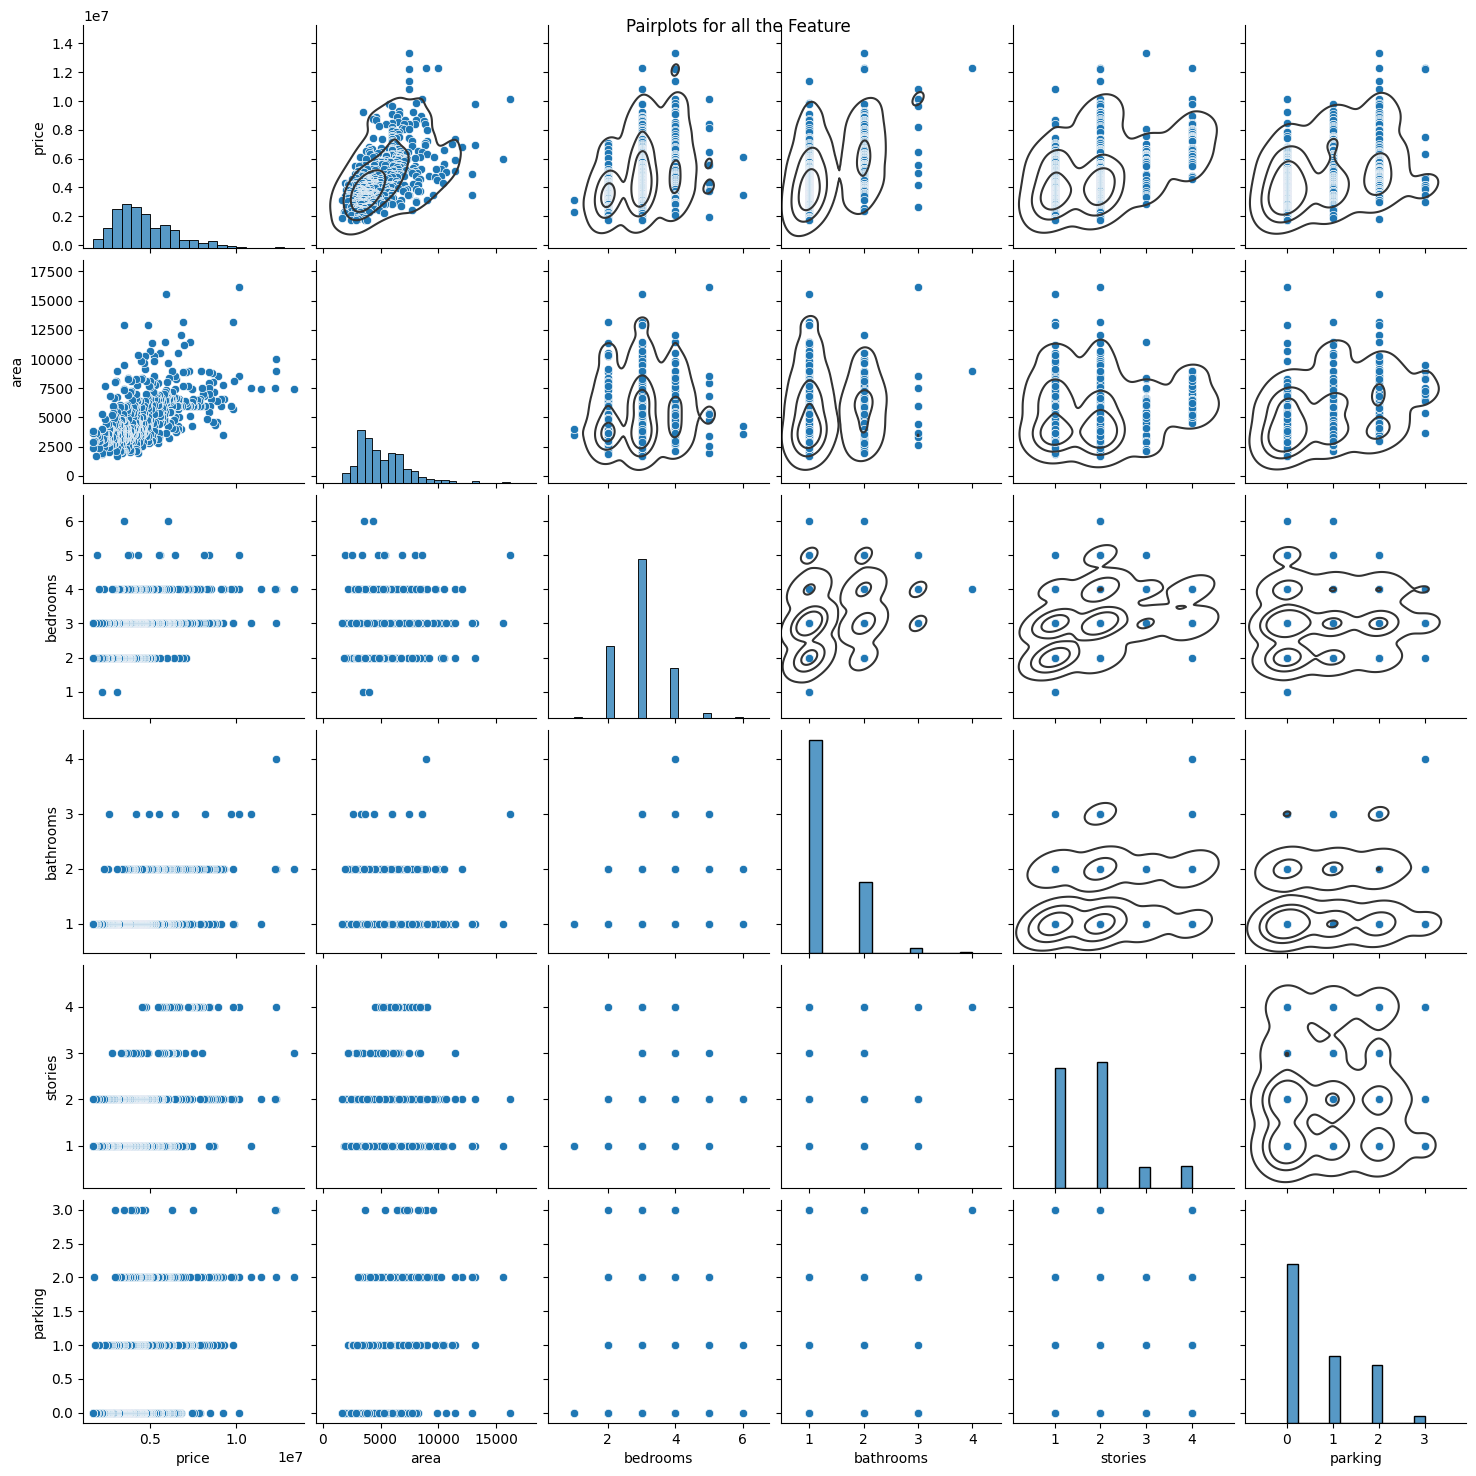

In [10]:
g = sns.pairplot(df)
g.fig.suptitle('Pairplots for all the Feature')
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()

In [11]:
counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print('\n\033[1mInference:\033[0m Number of duplicate dropped/fixed ---> {rs-df.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [12]:
nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                  Total Null Values  Percentage
price                             0         0.0
area                              0         0.0
bedrooms                          0         0.0
bathrooms                         0         0.0
stories                           0         0.0
mainroad                          0         0.0
guestroom                         0         0.0
basement                          0         0.0
hotwaterheating                   0         0.0
airconditioning                   0         0.0
parking                           0         0.0
prefarea                          0         0.0
furnishingstatus                  0         0.0


In [13]:
df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
oh=True
dm=True
for i in fcc:
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne Hot Encoding on features:\033[0m")
        print(i); oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if(df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:[0m")
        print(i); dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)

df3.shape

One Hot Encoding on features:
mainroad
guestroom
basement
hotwaterheating
airconditioning
prefarea

Dummy Encoding on features:
furnishingstatus
bathrooms
stories
parking
bedrooms


(545, 24)

In [14]:
df1 = df3.copy()

features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3-Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,price,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,...,stories_3,stories_4,parking_1,parking_2,parking_3,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
0,13300000,7420,True,False,False,False,True,True,False,False,...,True,False,False,True,False,False,False,True,False,False
1,12250000,8960,True,False,False,False,True,False,False,False,...,False,True,False,False,True,False,False,True,False,False
2,12250000,9960,True,False,True,False,False,True,True,False,...,False,False,False,True,False,False,True,False,False,False
3,12215000,7500,True,False,True,False,True,True,False,False,...,False,False,False,False,True,False,False,True,False,False
4,11410000,7420,True,True,True,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False



Inference:
Before removal of outliers, The dataset had 545 samples.
After removal of outliers, The dataset now has 533 samples.


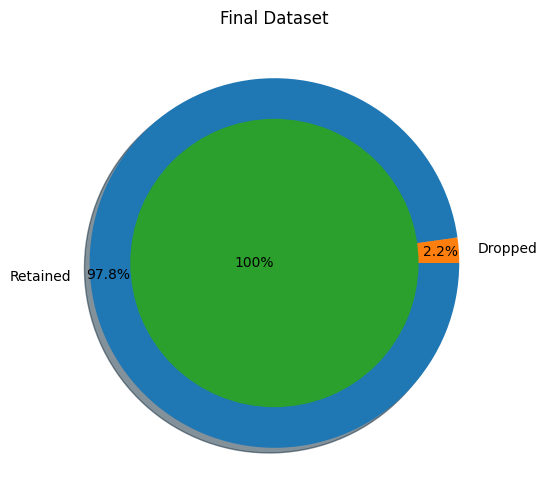


Inference: After the cleanup process, 12 samples were dropped, \while retaining 2.2% of the data.


In [15]:
df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius=1, labels=['Retained','Dropped'], counterclock=False, autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

In [16]:
m=[]

for i in df.columns.values:
    m.append(i.replace(' ','_'))

df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set ---> ',X.shape,Y.shape,'\nTraining set --->',Train_X.shape,Train_Y.shape,'\nTesting set ---> ',Test_X.shape,Test_Y.shape)

Original set --->  (533, 23) (533,) 
Training set ---> (426, 23) (426,) 
Testing set --->  (107, 23) (107,)


In [17]:
std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi_furnished,furnishingstatus_unfurnished,bathrooms_2,...,stories_3,stories_4,parking_1,parking_2,parking_3,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
count,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,...,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02
mean,-6.463270e-17,9.799152e-17,-2.501911e-17,1.250956e-17,-3.544374e-17,1.355202e-17,-2.918896e-17,-1.876433e-17,-3.752867e-17,2.084926e-17,...,2.501911e-17,1.667941e-17,-1.459448e-17,-1.355202e-17,8.339703e-17,-8.756689e-17,2.501911e-17,1.667941e-17,8.339703e-17,-4.169852e-18
std,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,...,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00
min,-1.797874e+00,-2.335497e+00,-4.659859e-01,-7.562775e-01,-2.038745e-01,-6.811149e-01,-5.393599e-01,-8.431153e-01,-6.996503e-01,-5.791573e-01,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,-5.972335e-01,-1.078164e+00,-4.585055e-01,-1.469106e-01,-4.850713e-02
25%,-7.487891e-01,4.281744e-01,-4.659859e-01,-7.562775e-01,-2.038745e-01,-6.811149e-01,-5.393599e-01,-8.431153e-01,-6.996503e-01,-5.791573e-01,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,-5.972335e-01,-1.078164e+00,-4.585055e-01,-1.469106e-01,-4.850713e-02
50%,-2.551019e-01,4.281744e-01,-4.659859e-01,-7.562775e-01,-2.038745e-01,-6.811149e-01,-5.393599e-01,-8.431153e-01,-6.996503e-01,-5.791573e-01,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,-5.972335e-01,9.275031e-01,-4.585055e-01,-1.469106e-01,-4.850713e-02
75%,6.110159e-01,4.281744e-01,-4.659859e-01,1.322266e+00,-2.038745e-01,1.468181e+00,-5.393599e-01,1.186077e+00,1.429286e+00,1.150196e+00,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,1.674387e+00,9.275031e-01,-4.585055e-01,-1.469106e-01,-4.850713e-02
max,2.992840e+00,4.281744e-01,2.145988e+00,1.322266e+00,4.904979e+00,1.468181e+00,1.854050e+00,1.186077e+00,1.429286e+00,1.726647e+00,...,3.699953e+00,3.633180e+00,1.829464e+00,2.032863e+00,6.806859e+00,1.674387e+00,9.275031e-01,2.180999e+00,6.806859e+00,2.061553e+01



                                          Standardardization on Testing set                                          


,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi_furnished,furnishingstatus_unfurnished,bathrooms_2,...,stories_3,stories_4,parking_1,parking_2,parking_3,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
count,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,...,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,1.070000e+02,107.000000
mean,0.025531,0.144059,0.022233,-0.154083,0.130350,0.001839,0.042216,0.029248,0.016627,-0.040418,...,0.063671,0.126559,0.008549,-0.019996,0.048055,-0.130171,0.121488,0.010192,-1.469106e-01,0.144615
std,1.021135,0.843283,1.023054,0.947331,1.269193,1.005431,1.031339,1.009305,1.010644,0.980290,...,1.107146,1.192583,1.010164,0.988902,1.153328,0.922384,0.987957,1.013435,2.788619e-17,1.997668
min,-1.635477,-2.335497,-0.465986,-0.756278,-0.203874,-0.681115,-0.539360,-0.843115,-0.699650,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,-1.078164,-0.458505,-1.469106e-01,-0.048507
25%,-0.809959,0.428174,-0.465986,-0.756278,-0.203874,-0.681115,-0.539360,-0.843115,-0.699650,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,-1.078164,-0.458505,-1.469106e-01,-0.048507
50%,-0.200970,0.428174,-0.465986,-0.756278,-0.203874,-0.681115,-0.539360,-0.843115,-0.699650,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,0.927503,-0.458505,-1.469106e-01,-0.048507
75%,0.762586,0.428174,-0.465986,1.322266,-0.203874,1.468181,-0.539360,1.186077,1.429286,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,0.927503,-0.458505,-1.469106e-01,-0.048507
max,2.867794,0.428174,2.145988,1.322266,4.904979,1.468181,1.854050,1.186077,1.429286,1.726647,...,3.699953,3.633180,1.829464,2.032863,6.806859,1.674387,0.927503,2.180999,-1.469106e-01,20.615528


                                       Correlation Matrix                                       


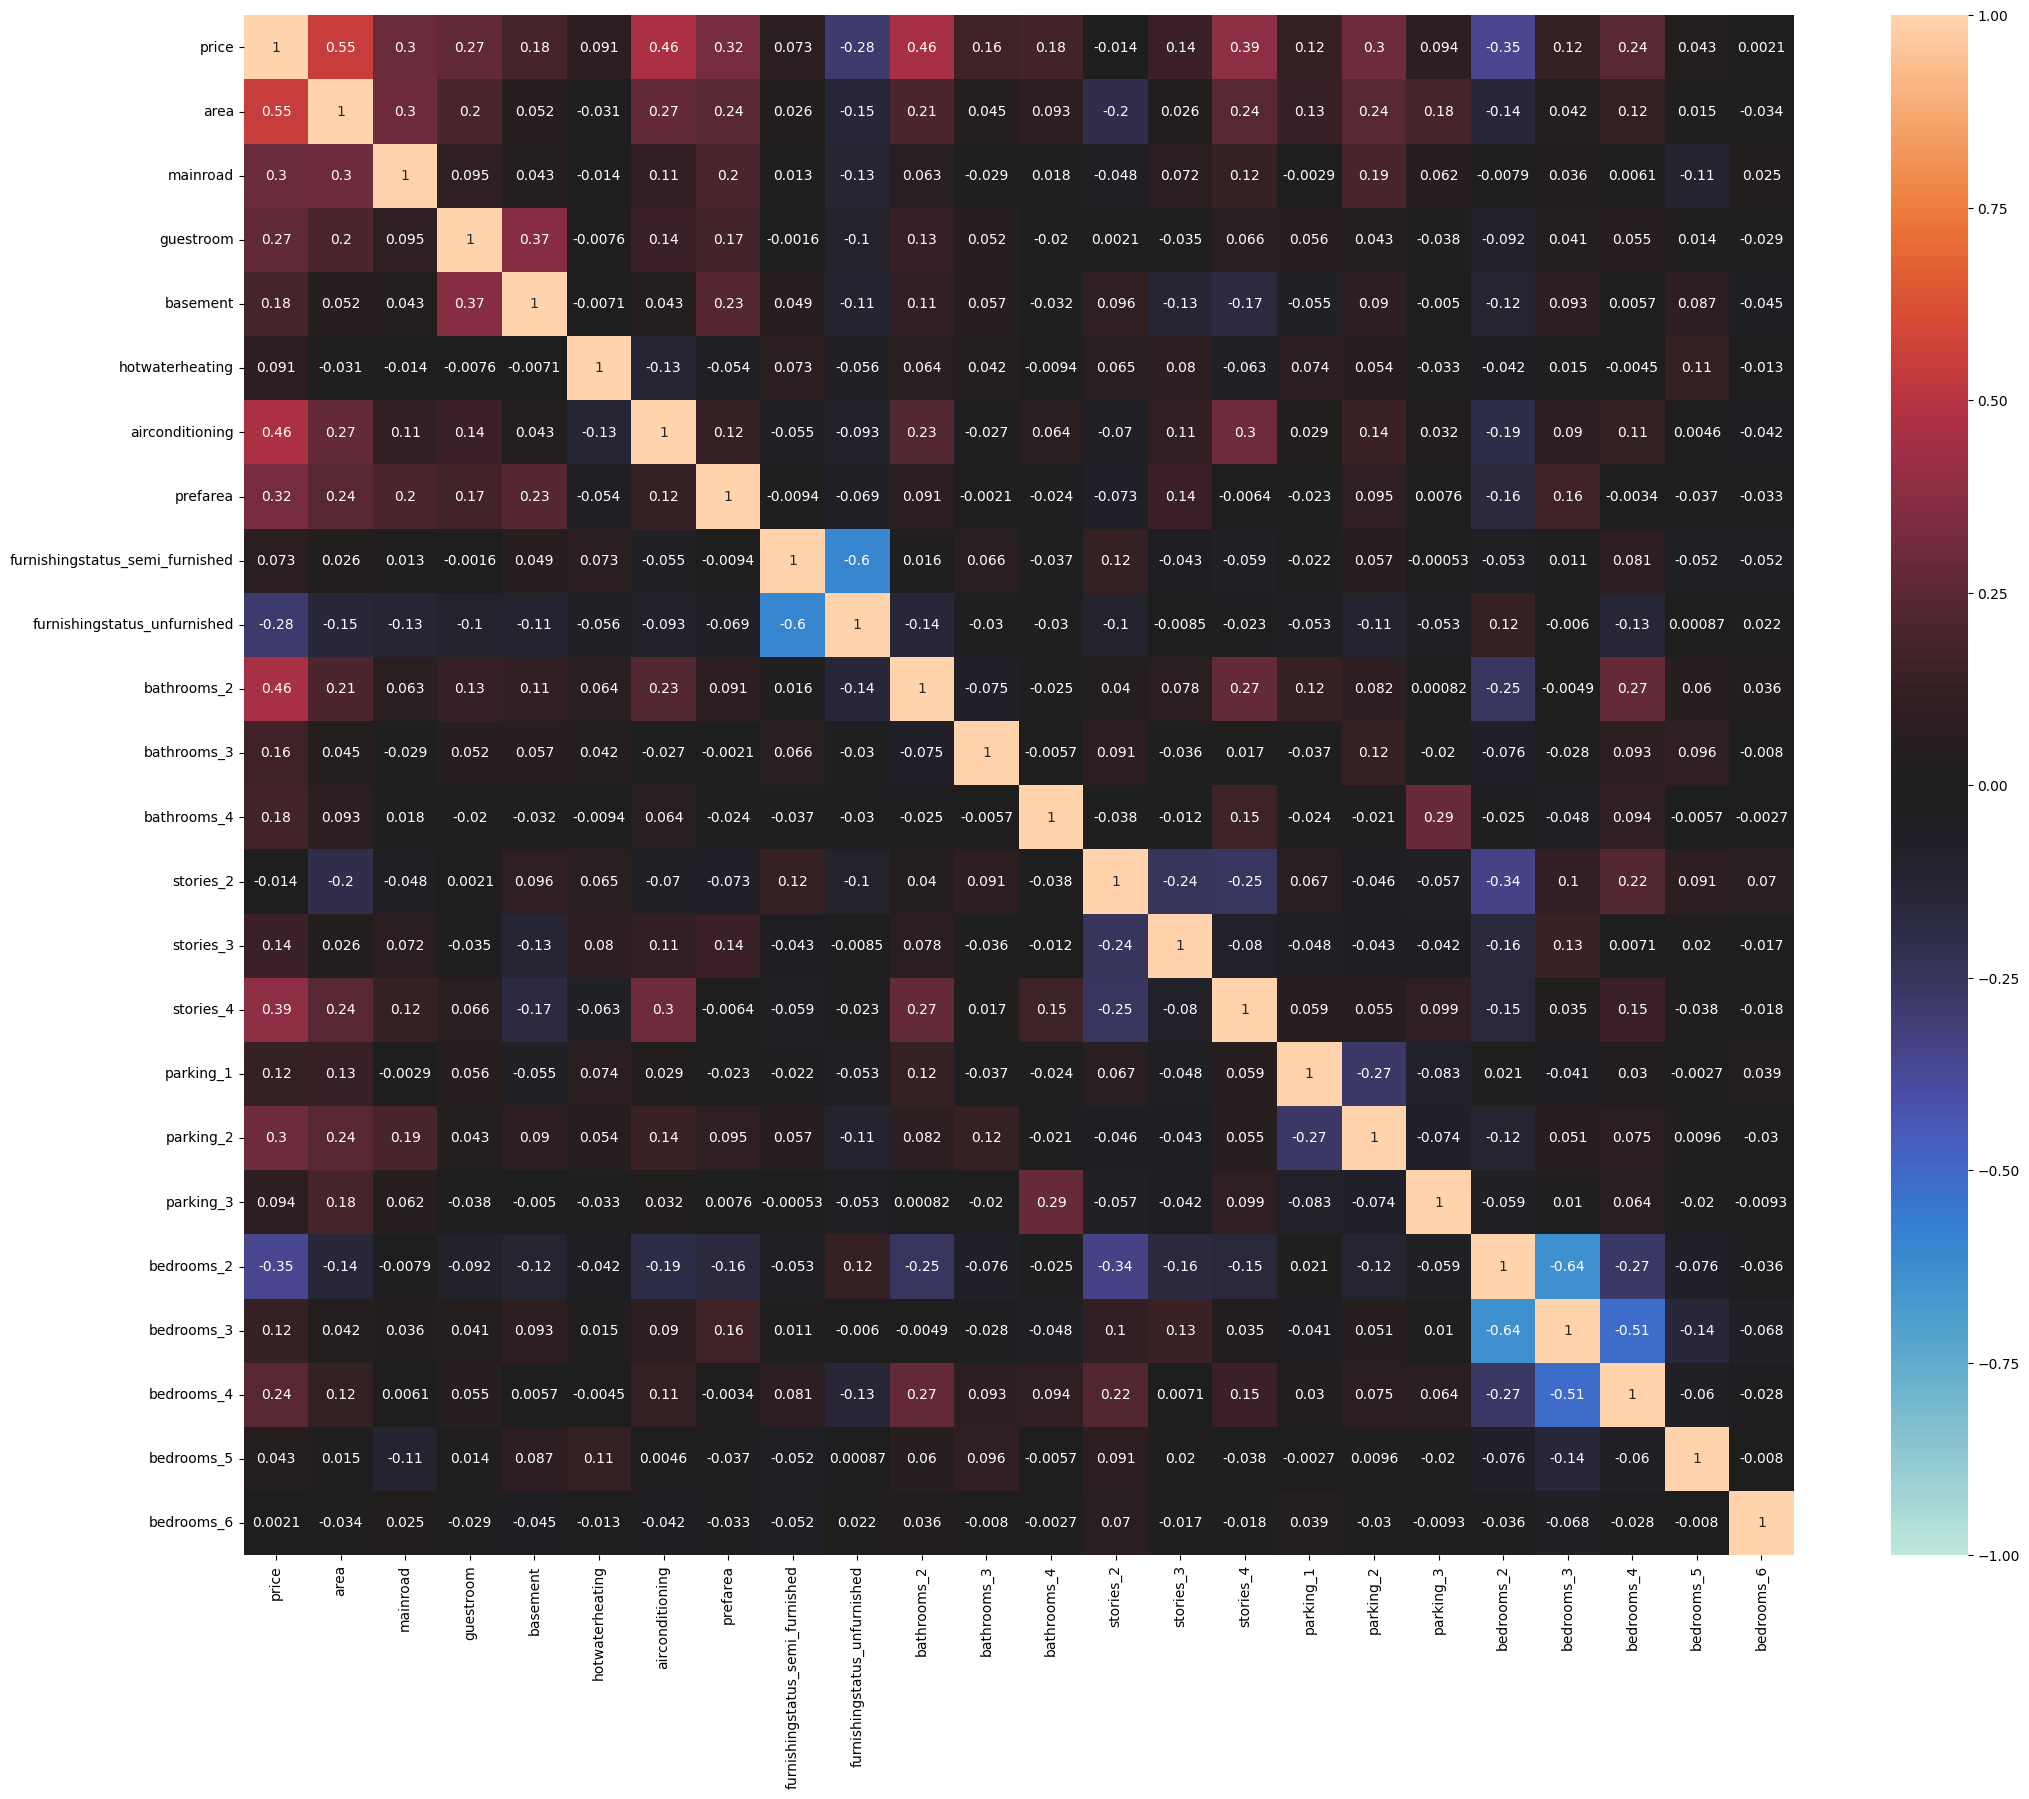

In [18]:
print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.show()

In [19]:
Train_xy = pd.concat([Train_X_std,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values
API = api.ols(formula='{}~{}'.format(target,'+'.join(i for i in Train_X.columns)), data=Train_xy).fit()
API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     36.96
Date:                Sat, 05 Aug 2023   Prob (F-statistic):           2.06e-84
Time:                        15:53:55   Log-Likelihood:                -6509.2
No. Observations:                 426   AIC:                         1.307e+04
Df Residuals:                     402   BIC:                         1.316e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        4.717e+06   5.22e+04     90.378      0.000    4.61e+06    4.82e+06
area                             4.356e+05   6.41e+04      6.799      0.000     3.1e+05    5.62e+05
mainroad                         1.785e+05   5.77e+04      3.092      0.002     6.5e+04    2.92e+05
guestroom                        1.197e+05   5.78e+04      2.071      0.039    6082.572    2.33e+05
basement                         1.712e+05   6.15e+04      2.784      0.006    5.03e+04    2.92e+05
hotwaterheating                  2.006e+05   5.48e+04      3.662      0.000    9.29e+04    3.08e+05
airconditioning                  3.635e+05   5.89e+04      6.168      0.000    2.48e+05    4.79e+05
prefarea                         2.711e+05   5.75e+04      4.711      0.000    1.58e+05    3.84e+05
furnishingstatus_semi_furnished  1.509e+04   6.71e+04      0.225      0.822   -1.17e+05    1.47e+05
furnishingstatus_unfurnished    -1.688e+05   6.78e+04     -2.489      0.013   -3.02e+05   -3.55e+04
bathrooms_2                      3.722e+05   5.98e+04      6.224      0.000    2.55e+05     4.9e+05
bathrooms_3                      1.886e+05    5.4e+04      3.492      0.001    8.24e+04    2.95e+05
bathrooms_4                      2.801e+05   5.68e+04      4.934      0.000    1.69e+05    3.92e+05
stories_2                        1.341e+05   6.97e+04      1.923      0.055   -2986.085    2.71e+05
stories_3                        2.289e+05   6.13e+04      3.735      0.000    1.08e+05    3.49e+05
stories_4                        3.725e+05   6.46e+04      5.764      0.000    2.45e+05       5e+05
parking_1                         1.67e+05   5.78e+04      2.887      0.004    5.33e+04    2.81e+05
parking_2                        2.781e+05   5.97e+04      4.662      0.000    1.61e+05    3.95e+05
parking_3                       -5.772e+04   5.72e+04     -1.009      0.314    -1.7e+05    5.47e+04
bedrooms_2                      -3.385e+04    4.8e+05     -0.070      0.944   -9.78e+05    9.11e+05
bedrooms_3                       1.077e+05   5.45e+05      0.197      0.844   -9.64e+05    1.18e+06
bedrooms_4                       1.215e+05   4.18e+05      0.291      0.771      -7e+05    9.43e+05
bedrooms_5                       3.933e+04   1.66e+05      0.237      0.812   -2.86e+05    3.65e+05
bedrooms_6                       8.462e+04   7.49e+04      1.130      0.259   -6.26e+04    2.32e+05
==============================================================================
Omnibus:                       96.025   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              274.474
Skew:                           1.058   Prob(JB):                     2.51e-60
Kurtosis:                       6.315   Cond. No.                  

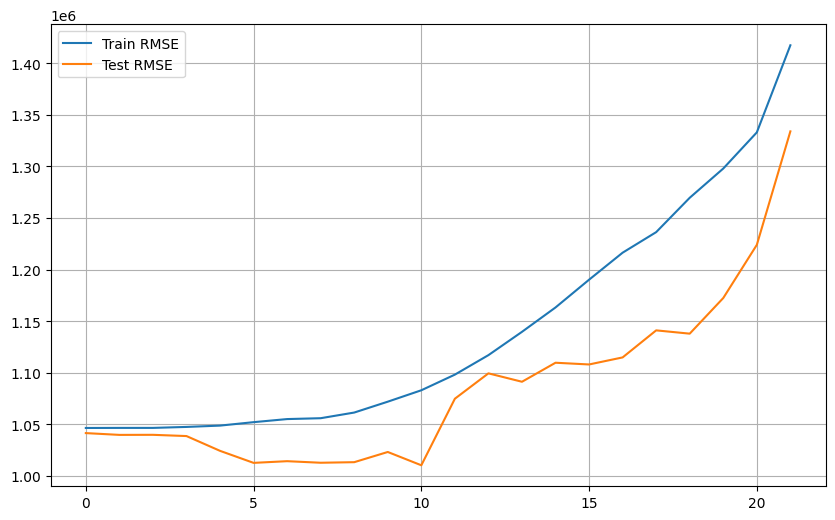

In [20]:
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)),  columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)),  columns=order)

m=df.shape[1]-2
for i in range(m):
    lm = LinearRegression()
    rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-i)
    rfe = rfe.fit(Train_X_std, Train_Y)

    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

    pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
    pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

In [21]:
lm = LinearRegression()
rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-5)
rfe = rfe.fit(Train_X_std, Train_Y)

LR = LinearRegression()
LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

print(np.sqrt(mean_squared_error(Train_Y, pred1)))
print(np.sqrt(mean_squared_error(Test_Y, pred2)))

1052002.1523301557
1012519.9893720058


In [22]:
Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS','Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,1,replace=False)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')
    plt.ylabel('y_pred')                       
    plt.show()

<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 434849.91176123  178990.05639646  119825.2647667   170770.38332747
  200249.17623357  363249.0167767   270699.69394281   15052.8419874
 -168922.68102789  371839.95056242  188214.33365361  279471.70539682
  132951.62984324  227966.31622315  371469.35951183  166740.86406293
  277604.61004215  -57376.64786896  -59857.52583878   79155.30405205
  100178.6068145    31307.10402315   81636.08479291]
The Intercept of the Regresion Model was found to be  4716708.779342723


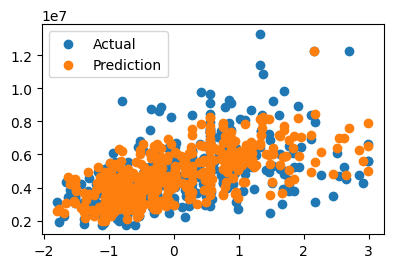



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.6789060979912986
Residual Sum of Squares (RSS) on Training set  ---> 466435055740620.5
Mean Squared Error (MSE) on Training set       ---> 1094917971222.1139
Root Mean Squared Error (RMSE) on Training set ---> 1046383.281222571

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.6868090228048058
Residual Sum of Squares (RSS) on Training set  ---> 115994836575477.69
Mean Squared Error (MSE) on Training set       ---> 1084063893228.7633
Root Mean Squared Error (RMSE) on Training set ---> 1041183.8902080473

--------------------Residual Plots--------------------


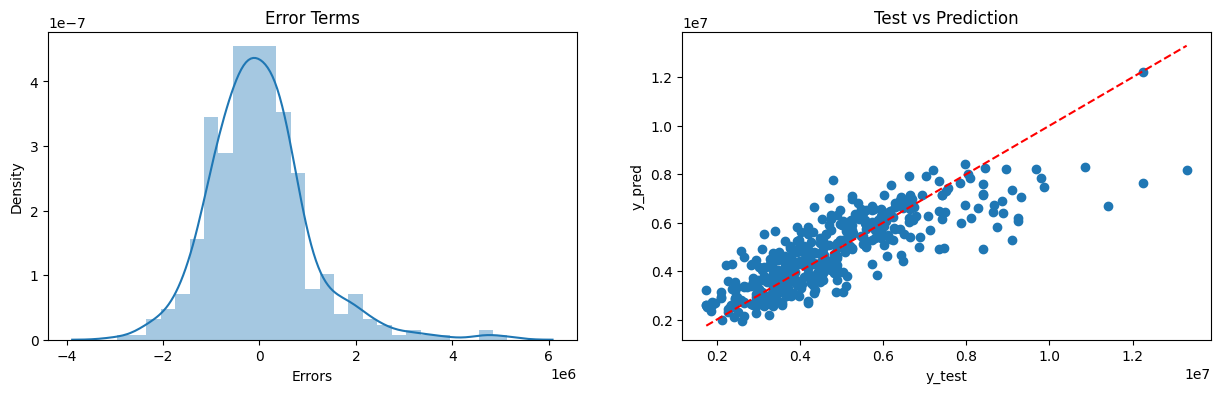

In [25]:
#Creating a Ridge Regression model

RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',RLR.coef_)
print('The Intercept of the Regresion Model was found to be ',RLR.intercept_)

Evaluate(1, pred1, pred2)